In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import dask.array as da

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

In [6]:
DATAPATH = "../../../data/DBLP/made/"
OUTPUTPATH = "../../../result/aminer/"
MODELPATH = "../../../result/aminer/model/"

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print("GPUを使っているかどうか？    {}".format(torch.cuda.is_available()))

GPUを使っているかどうか？    True


In [8]:
test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")

In [9]:
N = test_x.shape[0]
M = test_x.shape[2]
print("データサイズ: {}, {}, {}".format(N, N*N, M))

データサイズ: 2275, 5175625, 23


In [10]:
test_x, test_y = test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = torch.utils.data.TensorDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(M, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# ベースライン

In [12]:
model = Model()
model.load_state_dict(torch.load(MODELPATH+'nn_normal_max.pth'))
model.eval()
model.to(device)

Model(
  (fc1): Linear(in_features=23, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
%%time
actual_labels, pred_labels = np.empty(0), np.empty(0)
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    labels, outputs = labels.reshape(-1), outputs.reshape(-1)
    actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
    pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
print(pearsonr(actual_labels, pred_labels))

  0%|          | 0/80834 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(actual_labels, pred_labels)),3), 
    round(mean_squared_error(actual_labels, pred_labels),3),
    round(pearsonr(actual_labels, pred_labels)[0],3)))

RMSE: 10.505, MSE: 110.357, 相関係数: 0.4


In [12]:
df = pd.DataFrame(pred_labels, columns=["予測"])
df["実測"] = actual_labels
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.12

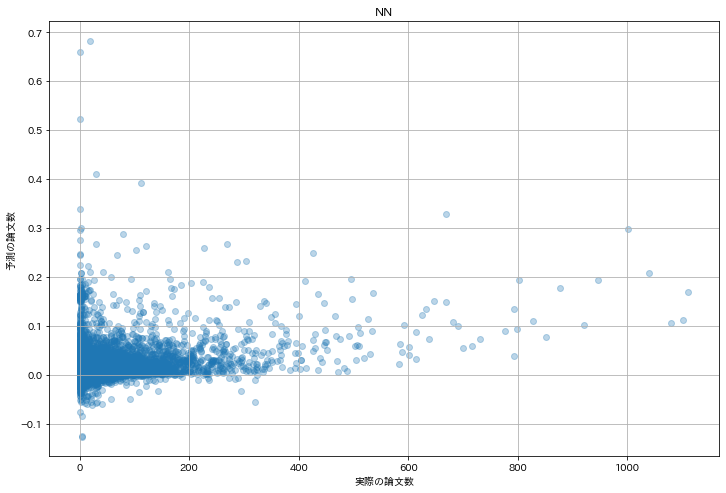

In [13]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.scatter(actual_labels, pred_labels, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("NN")
fig.savefig(OUTPUTPATH+"img/nn.png")
fig.show()

# 人気度

In [14]:
test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")

In [15]:
test_x, test_y = test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = torch.utils.data.TensorDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
model = Model()
model.load_state_dict(torch.load(MODELPATH+'nn_diff_max.pth'))
model.eval()
model.to(device)

Model(
  (fc1): Linear(in_features=23, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [17]:
actual_labels, pred_labels = np.empty(0), np.empty(0)
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    labels, outputs = labels.reshape(-1), outputs.reshape(-1)
    actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
    pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
print(pearsonr(actual_labels, pred_labels))

  0%|          | 0/23736 [00:00<?, ?it/s]

(0.7817287744736635, 0.0)


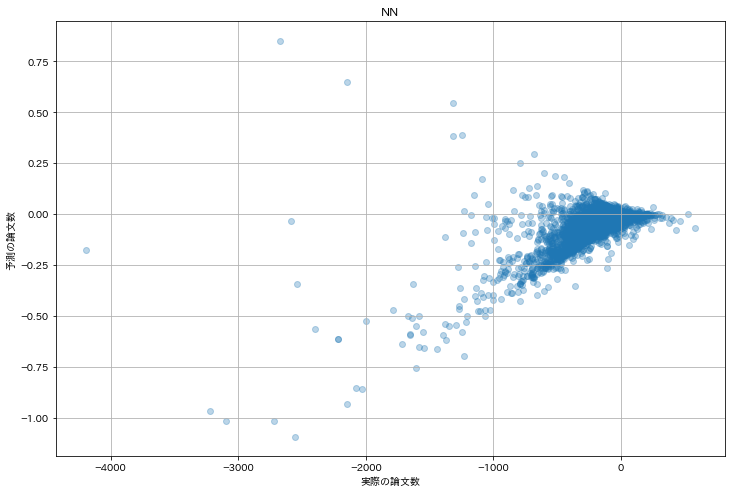

In [18]:
fig, ax = plt.subplots(facecolor="white", figsize=(12,8))
ax.scatter(actual_labels, pred_labels, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("NN")
fig.savefig(OUTPUTPATH+"img/nn_diff.png")
fig.show()

In [19]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(actual_labels, pred_labels)),3), 
    round(mean_squared_error(actual_labels, pred_labels),3),
    round(pearsonr(actual_labels, pred_labels)[0],3)))

RMSE: 30.524, MSE: 931.696, 相関係数: 0.782


In [20]:
df = pd.DataFrame(pred_labels, columns=["予測"])
df["実測"] = actual_labels
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.62